# Arbitrary State Generation

## Step 1: Computing pulse sequences

In this first section, we develop tools for computing the pulse sequences necessary for generating arbitrary resonator states. We follow the algorithm laid out in the paper, starting with the desired final state and then repetitively emptying the top Fock state into the qubit, and proceeding down the ladder to the ground state. 

First, let's import modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

Let's define some constants. 

In [2]:
t1q = 650  # qubit T1 in ns
t2q = 150  # qubit T2 in ns
t1r = 3500  # resonator T1 in ns
w_r = 2 * np.pi * 6.570  # resonator frequency in GHz
omega = 2 * np.pi * 19e-3  # qubit/cavity interaction strength in GHz
delta_on = 0  # qubit/cavity detuning when on resonance 
delta_off = - 2 * np.pi * 463e-3  # qubit/cavity detuning when off resonance in GHz
pulse_width = 8  # qubit drive pulse FWHM in ns
pulse_sig = pulse_width / (2 * np.sqrt(2 * np.log(2)))
pulse_time = 25  # the length of time to allow (should be more than twice pulse_width to get most of the Gaussian)
N = 10  # the number of Fock states to include
atol = 1e-3

And let's also define the operators we will need.

In [3]:
sm = tensor(sigmam(), identity(N))
a = tensor(identity(2), destroy(N))

There are three types of pulses: swap operations, qubit drive operations, and phase rotation operations. Let's write some functions to calculate the length of time each step needs to be applied for. Let's start with the swap operation. In the rest of this section, we imagine we are descending the ladder, as this is the order in which the operations are computed. In each step, we focus only on the two highest-energy components of whatever the complete state is.

The swap operation needs to take a superposition $c_1 | e, n-1 \rangle + c_2 |g, n\rangle$ and transfer it to pure $|e, n-1\rangle$. When the qubit is tuned on resonance, we have Rabi oscillations between these two states at a frequency $\sqrt{n}\Omega$. We note that the previous rotation operation has left these two states in phase with one another, so we can assume that the coefficients $c_1$ and $c_2$ are real. Thus the on-resonance pulse duration is simply 
\begin{equation}
\tau_n = \frac{2}{\sqrt{n}\Omega}\sin^{-1} (c_2 / c_1 ).
\end{equation}
Let's make a function for this.

In [4]:
def swap_time(n, c1, c2):
    """Computes the on-resonance time necessary to swap c1 |e, n-1> + c2 |g, n> down to pure |e, n-1>. 
    Returns time in units of omega."""
    if c1 == 0:
        return np.pi / np.sqrt(n)
    else:
        return 2 * np.arctan(np.abs(c2 / c1)) / np.sqrt(n)

Next, let's deal with the phase rotation operations. In the swap operation, we assumed that the two swap states were in phase with each other; in general, this will not be true following a qubit drive operation. Thus we need to engineer this to be true, which is what the phase rotation is for. The phase rotation is accomplished by leaving the qubit detuned from the resonator at the detuning freuency $\Delta_\text{off}$, which causes the $|e, n-1\rangle$ states to accumulate phase at a rate of $\Delta_\text{off}$ relative to the $|g, n+1\rangle$ states. Thus, given the coefficients $c_1$ and $c_2$ for $|e, n-1\rangle$ and $|g, n+1\rangle$ (which can now be complex), we know that the time of the phase pulse is 
\begin{equation}
    t_n = \Delta_\text{off}\text{Arg} (c_1 / c_2).
\end{equation}
Here is a function for this:

In [5]:
def rotation_time(c1, c2, lb=0):
    """Computes the detuning time necessary to get c1 |e, n-1> in phase with c2 |g, n>.
    Includes an optional argument for a lower bound lb, in case you want to specify that this time must
    be longer than the qubit drive operation.
    """
    t = np.angle(c2) - np.angle(c1)
    while (- t / delta_off) < lb:
        t = t + 2 * np.pi  # recall that delta_off is negative, hence the sign
    return t

Finally, we turn to the qubit drive operations, which are the most complicated. The qubit drive operations take place when the system is detuned and the two highest energy levels are $|e, n \rangle $ and $|g, n\rangle$. They need to take an arbitrary Bloch sphere vector $c_1 |e, n \rangle + c_2 |g, n\rangle$ and map it down to pure $|g, n\rangle$. The Hamiltonian in this situation is approximately
\begin{equation}
H = \Delta_\text{off} \sigma_+ \sigma_- + \frac{\Omega_q(t)}{2} \sigma_+ + \frac{\Omega_q^* (t)}{2} \sigma_- =
\Delta_\text{off} \sigma_+ \sigma_- + \text{Re} (\Omega_q (t)) \sigma^x + \text{Im}(\Omega_q(t)) \sigma^y,
\end{equation}
where the qubit/resonator interaction has been neglected because the detuning term is more important, and the cavity drive is turned off. We flip into the interaction picture with respect to the time-independent term of this Hamiltonian, and find that the ground state is unchanged while the excited state precesses at frequency $\Delta_\text{off}$. This corresponds to the Bloch sphere precessing around the $z$ axis. Thus whatever pulse we apply should be rotating by a phase factor
\begin{equation}
p(t) = e^{i\Delta_\text{off}t}
\end{equation}
The supplementary materials specify that the pulse is modulated by a Gaussian envelope with a FWHM of 8 ns. This corresponds to an envelope given by
\begin{equation}
g(t) = \frac{1}{\sqrt{2\pi w^2}}e^{(t-t_c)^2/2 w^2}, 
\end{equation}
where $w= \text{FWHM} / 2\sqrt{2\ln 2}$. 
The functional form of the pulse is thus 
\begin{equation}
\Omega_q (t) = (a + ib) g(t)  p(t),
\end{equation}
where $a + ib  = q_n $ is a prefactor which controls what axis we rotate the state about, and by how much.
The real part of the pulse will cause precession around the $x$ axis of the Bloch sphere and the imaginary part of the pulse will cause precession around the $y$ axis, so by picking these parameters correctly we can cause the state to rotate from an arbitrary location on the Bloch sphere down to pure $|g, n\rangle$. Specifically, we want to pick these parameters such that 
\begin{equation}
\text{Arg} (a + i b) = \frac{\pi}{2} + \text{Arg} (c_2 / c_1)
\end{equation}
and such that 
\begin{equation}
|a + ib| t_\text{max} = 2\sin^{-1} |c_2 / c_1 |.
\end{equation}
Note that we have a degree of freedom in the ratio of $t_\text{max}$ to $|a + ib|$. Let's pick $|a + ib| = \Delta_\text{off}$ so that this process is substantially stronger than the coupling term $\Omega$ (which is part of the approximation we made earlier when we dropped it). We can now write functions to compute these parameters:

In [6]:
def qubit_drive_phase(c1, c2):
    """Return the appropriate phase factor for the qubit drive pulse given a state c1 |e, n> + c2 |g, n>."""
    return np.angle(c2 / c1)


def qubit_drive_amp(c1, c2):
    """Return the appropriate amplitude for the qubit drive pulse given a state c1 |e, n> + c2 |g, n> and 
    assuming the drive time is pulse_time.
    """
    if c2 == 0:
        return np.pi
    else:
        return 2 * np.arctan(np.abs(c1 / c2))
    
def qubit_drive(c1, c2):
    """Returns the product of amplitude and phase."""
    return qubit_drive_amp(c1, c2) * np.exp(1j * qubit_drive_phase(c1, c2))

Now we are to the point of working out the actual pulse sequences for the time dependent Hamiltonian. 

Let's start by defining each component of the Hamiltonian.

In [7]:
Hq = delta_off * sm.dag() * sm  # the qubit only part of the Hamiltonian
Hc = omega * (sm * a.dag() + sm.dag() * a) / 2  # the qubit/resonator coupling term
Hd = sm.dag() / 2  # half of the qubit drive term. the other half will be included later - we need to conjugate 

Next, we need to start from the end state, and work our way backwards, calculating what happens to the state after the backwards evolution from the Hamiltonian at each step. Let's pick as an example $|1 \rangle + i |3\rangle$, as in the text.

In [8]:
psif = tensor(basis(2, 1), basis(N, 1) + 1j * basis(N, 3))
print(psif.data)

  (11, 0)	(1+0j)
  (13, 0)	1j


To avoid messing up indexing later, here's a function to access the coefficients of different states:

In [9]:
def get_ind(psi, q, r):
    """Access the |q, r> coefficient of psi (where q=0 is the excited state)."""
    return psi.full()[N * q + r, 0]

Also worth doing linspace stuff in one spot:

In [10]:
dt = 0.01
def time_axis(t, dt=0.01):
    """Returns a time axis for times 0 to t."""
    return np.linspace(0, t, int(t / dt))

Let's try implementing the first swap operation on this state:

In [11]:
psi = psif
n = 3
c1 = get_ind(psi, 0, n - 1)  # |e, n-1> 
c2 = get_ind(psi, 1, n)  # |g, n>
s = swap_time(n, c1, c2)
print(c1)
print(c2)
print(s)  # check we get the right value for the swap time; this should print 1.81
times = time_axis(s / omega)
result = sesolve(Hc, psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=atol)
print(psi.data)
psi0 = psi

0j
1j
1.8137993642342178
  (0, 0)	-0.5570576998628572j
  (2, 0)	(0.7069258522339451+0j)
  (11, 0)	(0.4358239994156881+0j)


Note: think about using Qobj.tidyup

This looks good though. Let's think about the qubit drive operation now. 

In [12]:
psi = psi0
n = 2
c1 = get_ind(psi, 0, n)  # |e, n> 
c2 = get_ind(psi, 1, n)  # |g, n>
driveamp = qubit_drive_amp(c1, c2)
drivephase = qubit_drive_phase(c1, c2)
print("Drive amp: %.2f" % driveamp)
print("Drive phase: %.2f" % drivephase)

times = time_axis(pulse_time)
def omegaq(t, args):
    return driveamp * np.exp(-1j * drivephase - 1j * t * delta_off 
                  - (1/2) * ((t - pulse_time / 2)**2) / (pulse_sig ** 2)) / np.sqrt(2 * np.pi * (pulse_sig**2))
def omegaqdag(t, args):
    return np.conj(omegaq(t, args))

print("Integral:")
print(np.sum(omegaq(times, []) * np.exp(1j * times * delta_off)) * dt)

result = sesolve([Hq, [Hd.dag(), omegaqdag], [Hd, omegaq]], psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=atol)
print("Psi data:")
print(psi.data)
psi0 = psi

Drive amp: 3.14
Drive phase: 0.00
Integral:
(3.1396061070349606+1.9890705293783286e-18j)
Psi data:
  (1, 0)	(-0.19762994753271027+0.3885038939910618j)
  (10, 0)	(-0.5570402130897257+0j)
  (12, 0)	-0.7069036609025872j


Just for reference, this is what the pulse looks like:

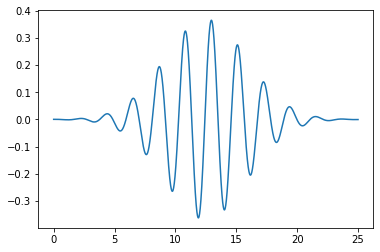

In [13]:
plt.figure()
plt.plot(times, np.real(omegaq(times, [])))
plt.show()

Great, now we ned to get the $|e, 1\rangle$ component in phase with the $|g, 2 \rangle$ component.

In [14]:
psi = psi0
n = 2
c1 = get_ind(psi, 0, n - 1)  # |e, n-1> 
c2 = get_ind(psi, 1, n)  # |g, n>
rotatetime = rotation_time(c1, c2)
print(rotatetime)
times = time_axis(- rotatetime / delta_off)
result = sesolve(Hq, psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=atol)
print("Psi data:")
print(psi.data)

2.6710133482029486
Psi data:
  (1, 0)	-0.4358576181867496j
  (10, 0)	(-0.5570476233181131+0j)
  (12, 0)	-0.7069130647435523j


Looks like all three types of pulses are working properly. Let's write some tools to do this more systematically. 

In [15]:
############ EVOLUTION ############
def evolve_swap(psi, pulse):
    """Implement swap pulse"""
    print("swap")
    times = time_axis(np.real(pulse) / omega)
    result = sesolve(-Hc, psi, times, [])
    psi = result.states[-1]
    return psi.tidyup(atol=atol)


def evolve_drive(psi, pulse):
    """Implement drive pulse"""
    print("drive")
    times = time_axis(pulse_time)
    
    def omegaq(t, args):
        return pulse * np.exp(1j * t * delta_off 
                      - (1/2) * ((t - pulse_time / 2)**2) / (pulse_sig ** 2)) / np.sqrt(2 * np.pi * (pulse_sig**2))
    def omegaqdag(t, args):
        return np.conj(omegaq(t, args))
    
    # print("Integral:")
    # print(np.sum(omegaq(times, []) * np.exp(1j * times * delta_off)) * dt)
    result = sesolve([-Hq, [-Hd.dag(), omegaqdag], [-Hd, omegaq]], psi, times, [])
    psi = result.states[-1]
    return psi.tidyup(atol=atol)
    
    
def evolve_rotation(psi, pulse):
    print("rotate")
    """Implement rotation pulse"""
    times = time_axis(- np.real(pulse) / delta_off)
    result = sesolve(-Hq, psi, times, [])
    psi = result.states[-1]
    return psi.tidyup(atol=atol)


############ CALCULATION ############
def swap_time(n, psi):
    """Computes the on-resonance time necessary to swap c1 |e, n-1> + c2 |g, n> down to pure |e, n-1>. 
    Returns time in units of omega."""
    c1 = get_ind(psi, 0, n - 1)
    c2 = get_ind(psi, 1, n)
    if c1 == 0:
        return np.pi / np.sqrt(n)
    else:
        return 2 * np.arctan(np.abs(c2 / c1)) / np.sqrt(n)
    
    
def qubit_drive(n, psi):
    """Returns the product of amplitude and phase."""
    c1 = get_ind(psi, 0, n - 1)
    c2 = get_ind(psi, 1, n - 1)
    return qubit_drive_amp(c1, c2) * np.exp(1j * qubit_drive_phase(c1, c2))
    
    
def rotation_time(n, psi, lb=0):
    """Computes the detuning time necessary to get c1 |e, n-1> in phase with c2 |g, n>.
    Includes an optional argument for a lower bound lb, in case you want to specify that this time must
    be longer than the qubit drive operation.
    """
    c1 = get_ind(psi, 0, n - 1)
    c2 = get_ind(psi, 1, n)
    t = np.angle(c1) - np.angle(c2) + 3 * np.pi / 2
    while (- t / delta_off) <= lb:
        t = t + 2 * np.pi  # recall that delta_off is negative, hence the sign
    return t



def calc_sequence(psif):
    """Calculates the pulse sequence for a given final state psif. Returns it as a list of values, 
    assuming that the first pulse is a qubit drive pulse. Note it can be off by a phase factor."""
    
    nmax = max(np.nonzero(psif.full()[N:, 0])[0])
    print("Top occupied Fock state is %d." % nmax)
    pulses = np.zeros(3 * nmax - 1, dtype=np.csingle)
    
    n = nmax
    psi = psif
    print(psi.data)
    
    # calculate first swap time
    pulses[-1] = swap_time(n, psi)
    print()
    print(pulses[-1])
    
    # apply first swap
    psi = evolve_swap(psi, pulses[-1])
    print(psi.data)
    
    # calculate first qubit drive
    pulses[-2] = qubit_drive(n, psi)
    print()
    print(pulses[-2])
    
    # apply first qubit drive
    psi = evolve_drive(psi, pulses[-2])
    print(psi.data)
    
    # work down the rest of the ladder:
    for n in np.arange(nmax - 1, 0, -1):
        
        # calculate rotation time
        pulses[3 * n - 1] = rotation_time(n, psi)
        print()
        print(pulses[3 * n - 1])
        
        # apply rotation 
        psi = evolve_rotation(psi, pulses[3 * n - 1])
        print(psi.data)
        
        # calculate swap time
        pulses[3 * n - 2] = swap_time(n, psi)
        print()
        print(pulses[3 * n - 2])
        
        # apply swap 
        psi = evolve_swap(psi, pulses[3 * n - 2])
        print(psi.data)
        
        # calculate qubit drive
        pulses[3 * n - 3] = qubit_drive(n, psi)
        print()
        print(pulses[3 * n - 3])
        
        # apply qubit drive 
        psi = evolve_drive(psi, pulses[3 * n - 3])
        print(psi.data)
        
    print()
    return pulses
            
    
psif = tensor(basis(2, 1), basis(N, 1) + 1j * basis(N, 3)) / np.sqrt(2)
pulses = calc_sequence(psif)

print(pulses)

Top occupied Fock state is 3.
  (11, 0)	(0.7071067811865475+0j)
  (13, 0)	0.7071067811865475j

(1.8137994+0j)
swap
  (0, 0)	0.5570577035726526j
  (2, 0)	(-0.7069258522332862+0j)
  (11, 0)	(0.4358239946750113+0j)

(-3.1415927-3.8473414e-16j)
drive
  (1, 0)	(0.19762994532770356+0.3885038897084145j)
  (10, 0)	(0.5570402168258074+0j)
  (12, 0)	0.7069036609354424j

(4.24181+0j)
rotate
  (1, 0)	(-0.43584307850436305+0j)
  (10, 0)	(0.5570519830749772+0j)
  (12, 0)	0.7069185927201899j

(1.4400997+0j)
swap
  (1, 0)	(-0.8303229748472882+0j)
  (10, 0)	(0.557282475447271+0j)

(-3.1415927-3.8473414e-16j)
drive
  (0, 0)	(0.2526291721263819+0.4966986429299919j)
  (11, 0)	0.8303421532181466j

(4.241872+0j)
rotate
  (0, 0)	(-0.5572113961612642+0j)
  (11, 0)	0.8303706739673655j

(1.9595451+0j)
swap
  (0, 0)	(-0.9999999999999054+0j)

(-3.1415927-3.8473414e-16j)
drive
  (10, 0)	0.9999994669844531j

[-3.1415927-3.8473414e-16j  1.9595451+0.0000000e+00j
  4.241872 +0.0000000e+00j -3.1415927-3.8473414e-16j
  

Looks good! We end up in the ground state, as desired. Now we need to design the forward-time evolution. 

## Step 2: Creating arbitrary states using pulse sequences

If we want to do this via density matrix with collapse operators, then we need to do the whole evolution in one go. That means we need the complete time dependence of the operators. Let's work these out now.

In [16]:

p = pulses

start_times = np.real(p) + 0  # to make it a new array
start_times[0::3] = pulse_time
start_times[1::3] = start_times[1::3] / omega
start_times[2::3] = - start_times[2::3] / delta_off
start_times = np.cumsum(start_times)
start_times = np.concatenate(([0], start_times))
print("Start times:")
print(start_times)

# get start and stop points for detuning
start_detune = np.concatenate(([0], start_times[2:-1:3]))
# print(start_detune)
stop_detune = start_times[1::3]
# print(stop_detune)
start_detune = np.concatenate((start_detune, np.zeros(N - len(start_detune))))
stop_detune = np.concatenate((stop_detune, np.zeros(N - len(stop_detune))))

# get info for gaussian pulses
gauss_c = start_times[0::3] + pulse_time / 2  # centers
# print(gauss_c)
gauss_a = p[0::3]  # amplitudes
# print(gauss_a)
gauss_c = np.concatenate((gauss_c, np.zeros(N - len(gauss_c))))
gauss_a = np.concatenate((gauss_a, np.zeros(N - len(gauss_a), dtype=np.csingle)))

# get time axis (here we will use the array version of defining time dependence)
dt = 0.01
times = time_axis(start_times[-1], dt=dt)



####### THIS SECTION IS DEPROCATED BUT PRESERVED IN CASE ITS IMPORTANT LATER #######
def delta(t, args):
    return np.sign(1. * (
        np.bitwise_and(t > start_detune[0], t < stop_detune[0])
        + np.bitwise_and(t > start_detune[1], t < stop_detune[1])
        + np.bitwise_and(t > start_detune[2], t < stop_detune[2])
        + np.bitwise_and(t > start_detune[3], t < stop_detune[3])
        + np.bitwise_and(t > start_detune[4], t < stop_detune[4])
        + np.bitwise_and(t > start_detune[5], t < stop_detune[5])
        + np.bitwise_and(t > start_detune[6], t < stop_detune[6])
        + np.bitwise_and(t > start_detune[7], t < stop_detune[7])
        + np.bitwise_and(t > start_detune[8], t < stop_detune[8])
        + np.bitwise_and(t > start_detune[9], t < stop_detune[9])
    ))

def gauss(c, a, t):
    return a * np.exp(- 1j * t * delta_off 
                      - (1/2) * ((t - c / 2)**2) / (pulse_sig ** 2)) / np.sqrt(2 * np.pi * (pulse_sig**2))

def drive(t, args):
    return (
        gauss(gauss_c[0], gauss_a[0], t)
        + gauss(gauss_c[1], gauss_a[1], t)
        + gauss(gauss_c[2], gauss_a[2], t)
        + gauss(gauss_c[3], gauss_a[3], t)
        + gauss(gauss_c[4], gauss_a[4], t)
        + gauss(gauss_c[5], gauss_a[5], t)
        + gauss(gauss_c[6], gauss_a[6], t)
        + gauss(gauss_c[7], gauss_a[7], t)
        + gauss(gauss_c[8], gauss_a[8], t)
        + gauss(gauss_c[9], gauss_a[9], t)
    )

def drivedag(t, args):
    return np.conj(drive(t, args))

##################### END DEPROCATED #####################



# define delta
delta = np.zeros_like(times)
for i in range(len(start_detune)):
    delta[np.bitwise_and(times >= start_detune[i], times < stop_detune[i])] = 1
# print(delta)

# define drive
drive = np.zeros_like(times)
for i in range(len(gauss_c)):
    drive = (drive
             + gauss_a[i] * np.exp(- 1j * times * delta_off)
             * np.exp(- (1/2) * ((times - gauss_c[i])**2) / (pulse_sig ** 2)) 
             / np.sqrt(2 * np.pi * (pulse_sig**2)))
# print(drive)
drivedag = np.conj(drive)




Htot = [Hc, [Hq, delta], [Hd, drive], [Hd.dag(), drivedag]]
psi0 = tensor(basis(2, 1), basis(N, 0))

result = sesolve(Htot, psi0, times, [])
for i in range(start_times.size - 1):
    print()
    print("Step %d: %s" % (i, ["drive", "swap", "rotate"][(i - 1) % 3]))
    print(result.states[int(start_times[i] / dt)].tidyup(atol=5e-2).data)
psif = result.states[-1]
psif.tidyup(atol=1e-1)
print()
print("Swap, and final state:")
print(psif.data)

Start times:
[  0.          25.          41.41427612  42.87240601  67.87240601
  79.93550873  81.39361572 106.39361572 121.58704376]

Step 0: rotate
  (10, 0)	(1+0j)

Step 1: drive
  (0, 0)	(0.4643842643280601-0.8853850601872169j)

Step 2: swap
  (0, 0)	(0.2793183370592811-0.4821334896201098j)
  (11, 0)	(-0.7411716669689069-0.374397789751708j)

Step 3: rotate
  (0, 0)	(-0.570795917931398-0.06039368647508994j)
  (11, 0)	(-0.7244320633185544-0.3817365578435575j)

Step 4: drive
  (1, 0)	0.8287693593565156j
  (10, 0)	(0.4818842542427331-0.2820596576796776j)

Step 5: swap
  (1, 0)	0.43362009020508924j
  (10, 0)	(0.4820722166216336-0.28216938125880314j)
  (12, 0)	(0.7058684703293351+0j)

Step 6: rotate
  (1, 0)	(0.4346824559594561-0.1385672131738872j)
  (10, 0)	(0.48209291632225415-0.28218167305212233j)
  (12, 0)	(0.692225515349384+0j)

Step 7: drive
  (0, 0)	(-0.5090454255497018+0.248402811673453j)
  (2, 0)	(-0.7011044923824007-0.06563501259035154j)
  (11, 0)	(-0.4251410177699454+0j)

Swap,

I can't figure out why we are ending up with such a large proportion of |e, 0> in the final state.